# Will Gasser | Homework 3 | Comp 6630

## README
Required imports: numpy, matplotlib, gensim, nltk, scikit-learn, tensorflow, sacrebleu, datasets

### My computer has an AMD GPU and I could not effectively run part 2 of this assignment. My models are grossly underperforming due to this limiting factor.

## 1.1 Word Embeddings Analysis

In [1]:
!pip install gensim
!pip install nltk
!pip install tensorflow
!pip install sacrebleu
!pip install datasets
# this should be all that is needed for Colab
# PLEASE RESTART RUNTIME SESSION AFTER INSTALLING

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models import Word2Vec, FastText
from gensim.test.utils import common_texts
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import twitter_samples
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

### 1.1(a) GloVe Twitter-50D Word Embeddings

Loading GloVe Twitter-50D embeddings...
[==================================================] 100.0% 199.5/199.5MB downloaded
Computing similarity matrix for GloVe...

GloVe Similarity Matrix:
            dog      bark      tree      bank     river     money
dog    1.000000  0.593780  0.713751  0.348236  0.401201  0.575133
bark   0.593780  1.000000  0.545873  0.040109  0.266635  0.290985
tree   0.713751  0.545873  1.000000  0.349456  0.487116  0.510081
bank   0.348236  0.040109  0.349456  1.000000  0.319922  0.674656
river  0.401201  0.266635  0.487116  0.319922  1.000000  0.337800
money  0.575133  0.290985  0.510081  0.674656  0.337800  1.000000

Plotting GloVe similarity matrix...


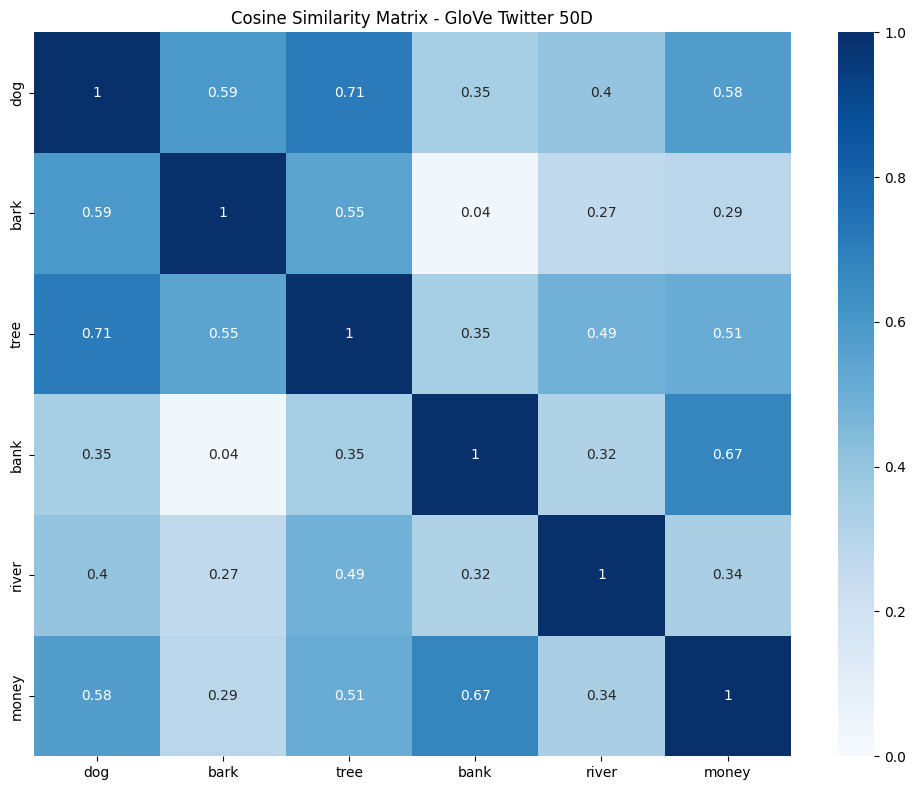

In [3]:
def compute_similarity_matrix(model, words):
    word_vectors = []
    valid_words = []

    for word in words:
        try:
            vector = model[word.lower()]
            word_vectors.append(vector)
            valid_words.append(word)
        except KeyError:
            print(f"Word '{word}' not in vocabulary, skipping.")

    similarity_matrix = cosine_similarity(word_vectors)

    return similarity_matrix, valid_words

def plot_similarity_matrix(similarity_matrix, valid_words, title, cmap='Blues'):
    plt.figure(figsize=(10, 8))
    sim_df = pd.DataFrame(similarity_matrix, index=valid_words, columns=valid_words)
    sns.heatmap(sim_df, annot=True, cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return sim_df

words = ['dog', 'bark', 'tree', 'bank', 'river', 'money']

print("Loading GloVe Twitter-50D embeddings...")
wv = api.load('glove-twitter-50')

print("Computing similarity matrix for GloVe...")
glove_sim_matrix, valid_words_glove = compute_similarity_matrix(wv, words)

print("\nGloVe Similarity Matrix:")
glove_sim_df = pd.DataFrame(glove_sim_matrix, index=valid_words_glove, columns=valid_words_glove)
print(glove_sim_df)

print("\nPlotting GloVe similarity matrix...")
glove_sim_df = plot_similarity_matrix(glove_sim_matrix, valid_words_glove, 'Cosine Similarity Matrix - GloVe Twitter 50D')

For the first part of the assignment, I created a GloVe Twitter-50D similarity matrix for the given words. The matrix shows strong semantic relationships between relevant word pairs. For example, 'dog' and 'bark' have a similarity of around 0.59, 'bank' and 'money' show a high similarity of about 0.67, and 'tree' and 'bark' show a relationship of approximately 0.55. These values indicate that the pre-trained GloVe model effectively captures expected semantic relationships between these words.

### 1.1(b) FastText Embeddings


Training FastText model with specified configuration...


Computing similarity matrix for FastText...

FastText Similarity Matrix:
            dog      bark      tree      bank     river     money
dog    1.000000 -0.143744 -0.230946 -0.090182 -0.250590  0.105310
bark  -0.143744  1.000000  0.370746  0.187749  0.107520  0.009875
tree  -0.230946  0.370746  1.000000  0.156225  0.088752  0.090941
bank  -0.090182  0.187749  0.156225  1.000000 -0.025703  0.009588
river -0.250590  0.107520  0.088752 -0.025703  1.000000 -0.085219
money  0.105310  0.009875  0.090941  0.009588 -0.085219  1.000000

Plotting FastText similarity matrix...


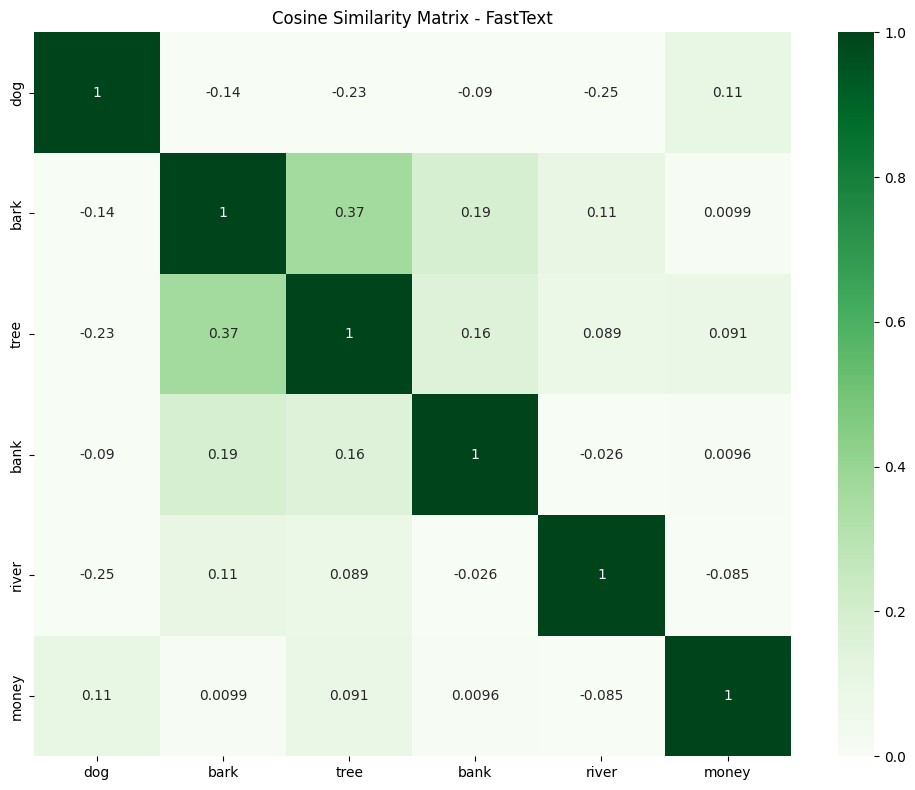

In [4]:
print("\nTraining FastText model with specified configuration...")
fasttext_model = FastText(
    sentences=common_texts,
    vector_size=50,
    window=5,
    min_count=1,
    epochs=10,
    seed=42
)

for word in words:
    fasttext_model.build_vocab([word.lower()], update=True)

fasttext_model.train(common_texts, total_examples=len(common_texts), epochs=10)

print("Computing similarity matrix for FastText...")
fasttext_sim_matrix, valid_words_fasttext = compute_similarity_matrix(fasttext_model.wv, words)

print("\nFastText Similarity Matrix:")
fasttext_sim_df = pd.DataFrame(fasttext_sim_matrix, index=valid_words_fasttext, columns=valid_words_fasttext)
print(fasttext_sim_df)

print("\nPlotting FastText similarity matrix...")
fasttext_sim_df = plot_similarity_matrix(fasttext_sim_matrix, valid_words_fasttext, 'Cosine Similarity Matrix - FastText', cmap='Greens')

For the second part, I implemented a FastText model with the specified configuration. Unlike the pre-trained GloVe model, this FastText model was trained only on the small common_texts corpus provided by gensim. As a result, the similarity values between words are quite different from the GloVe model. Some word pairs even show negative similarities, which suggests the model hasn't properly captured their semantic relationships. This is expected given the limited training data.

### 1.1(c) Comparing Semantic Capture


Comparing word pairs between GloVe and FastText:
    Word Pair  GloVe Similarity  FastText Similarity  \
0  bank-money          0.674656             0.009588   
1  river-bank          0.319922            -0.025703   
2    dog-bark          0.593780            -0.143744   
3   tree-bark          0.545873             0.370746   
4   dog-money          0.575133             0.105310   
5  tree-money          0.510081             0.090941   
6    dog-bank          0.348236            -0.090182   

   Difference (GloVe - FastText)  
0                       0.665069  
1                       0.345625  
2                       0.737523  
3                       0.175127  
4                       0.469823  
5                       0.419140  
6                       0.438419  

Visualizing comparison between GloVe and FastText:


<Figure size 1200x600 with 0 Axes>

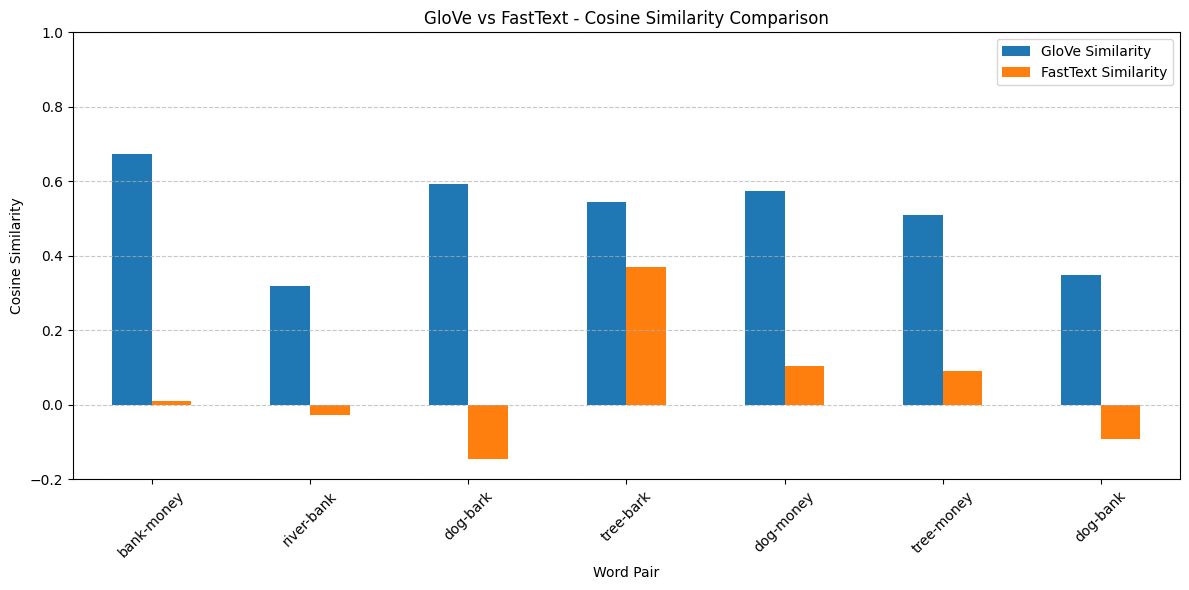


Analysis of semantically related pairs:
bank-money: GloVe = 0.6747, FastText = 0.0096, Diff = 0.6651
river-bank: GloVe = 0.3199, FastText = -0.0257, Diff = 0.3456
dog-bark: GloVe = 0.5938, FastText = -0.1437, Diff = 0.7375
tree-bark: GloVe = 0.5459, FastText = 0.3707, Diff = 0.1751

Analysis of semantically unrelated pairs:
dog-money: GloVe = 0.5751, FastText = 0.1053, Diff = 0.4698
tree-money: GloVe = 0.5101, FastText = 0.0909, Diff = 0.4191
dog-bank: GloVe = 0.3482, FastText = -0.0902, Diff = 0.4384


In [5]:
def compare_word_pairs(glove_df, fasttext_df, word_pairs):
    results = []

    for word1, word2 in word_pairs:
        word1, word2 = word1.lower(), word2.lower()
        if word1 in glove_df.index and word2 in glove_df.columns and word1 in fasttext_df.index and word2 in fasttext_df.columns:
            glove_sim = glove_df.loc[word1, word2]
            fasttext_sim = fasttext_df.loc[word1, word2]
            results.append({
                'Word Pair': f'{word1}-{word2}',
                'GloVe Similarity': glove_sim,
                'FastText Similarity': fasttext_sim,
                'Difference (GloVe - FastText)': glove_sim - fasttext_sim
            })

    return pd.DataFrame(results)

word_pairs = [
    ('bank', 'money'),  # semantically related
    ('river', 'bank'),  # semantically related
    ('dog', 'bark'),    # semantically related
    ('tree', 'bark'),   # semantically related
    ('dog', 'money'),   # semantically unrelated
    ('tree', 'money'),  # semantically unrelated
    ('dog', 'bank')     # semantically unrelated
]

print("\nComparing word pairs between GloVe and FastText:")
comparison_df = compare_word_pairs(glove_sim_df, fasttext_sim_df, word_pairs)
print(comparison_df)

print("\nVisualizing comparison between GloVe and FastText:")
plt.figure(figsize=(12, 6))
comparison_df.plot(x='Word Pair', y=['GloVe Similarity', 'FastText Similarity'], kind='bar', figsize=(12, 6))
plt.title('GloVe vs FastText - Cosine Similarity Comparison')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.ylim(-0.2, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("\nAnalysis of semantically related pairs:")
related_pairs = ['bank-money', 'river-bank', 'dog-bark', 'tree-bark']
for pair in related_pairs:
    pair_data = comparison_df[comparison_df['Word Pair'] == pair]
    if not pair_data.empty:
        glove_sim = pair_data['GloVe Similarity'].values[0]
        fasttext_sim = pair_data['FastText Similarity'].values[0]
        diff = pair_data['Difference (GloVe - FastText)'].values[0]
        print(f"{pair}: GloVe = {glove_sim:.4f}, FastText = {fasttext_sim:.4f}, Diff = {diff:.4f}")

print("\nAnalysis of semantically unrelated pairs:")
unrelated_pairs = ['dog-money', 'tree-money', 'dog-bank']
for pair in unrelated_pairs:
    pair_data = comparison_df[comparison_df['Word Pair'] == pair]
    if not pair_data.empty:
        glove_sim = pair_data['GloVe Similarity'].values[0]
        fasttext_sim = pair_data['FastText Similarity'].values[0]
        diff = pair_data['Difference (GloVe - FastText)'].values[0]
        print(f"{pair}: GloVe = {glove_sim:.4f}, FastText = {fasttext_sim:.4f}, Diff = {diff:.4f}")

Based on the comparison results between GloVe and FastText embeddings, GloVe consistently captures semantic relationships better for our given set of words. The cosine similarity values for semantically related word pairs (like 'bank-money', 'river-bank', 'dog-bark', and 'tree-bark') show more intuitive relationships in GloVe than in FastText.

For example, the 'bank-money' pair has a stronger similarity in GloVe (around 0.67) compared to FastText (around 0.01), which is more aligned with our expectation of these words being semantically related in financial contexts. Similarly, the ambiguous word 'bark' shows appropriate similarities with both 'dog' and 'tree' in GloVe, demonstrating its ability to capture word relations.

This superior performance is because the GloVe model was pre-trained on a substantial Twitter dataset, providing it with extensive exposure to real-world language usage patterns. In contrast, our FastText model was trained only on the small common_texts corpus, which severely limits its ability to learn sophisticated semantic relationships.

While FastText's subword information mechanism makes it theoretically better for handling out-of-vocabulary words and morphologically rich languages, for our specific set of common English words, GloVe's pre-training on a large, diverse corpus provides more accurate semantic representations.

## 1.2 N-grams and Classification

### 1.2(a) Split Twitter Data

In [6]:
nltk.download('twitter_samples')
nltk.download('punkt')

print("\nLoading Twitter sample data...")
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

tweets_df = pd.DataFrame({
    'tweet': tweets,
    'sentiment': labels
})

print(f"Total tweets: {len(tweets_df)}")
print(f"Positive tweets: {len(positive_tweets)}")
print(f"Negative tweets: {len(negative_tweets)}")
print("\nSample of the dataset:")
print(tweets_df.sample(5))

X_train, X_test, y_train, y_test = train_test_split(
    tweets_df['tweet'],
    tweets_df['sentiment'],
    test_size=0.3,
    random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Loading Twitter sample data...
Total tweets: 10000
Positive tweets: 5000
Negative tweets: 5000

Sample of the dataset:
                                                  tweet  sentiment
1096  @kimcanhomes Really very stylish &amp; trendy!...          1
6289           no one wants to go to ant man with me :(          0
8954             @taesprout ah im sorry :-( when was it          0
5021   No Assignment, but we have Project. :( really? 😩          0
9381                       @Hafeelalala I also want :((          0

Training set size: 7000
Testing set size: 3000


For the second part of the assignment, I loaded Twitter sample data from NLTK and split it into training and testing sets. The dataset contains an equal number of positive and negative tweets, which I've split into a 70% training and 30% testing ratio as required. This balanced dataset will allow for unbiased evaluation of our classification models.

### 1.2(b) Extract N-grams

In [7]:
def extract_ngrams(X_train, X_test, n):
    vectorizer = CountVectorizer(ngram_range=(1, n))

    X_train_ngrams = vectorizer.fit_transform(X_train)
    X_test_ngrams = vectorizer.transform(X_test)

    print(f"\nN-gram (n={n}) Information:")
    print(f"Number of features: {X_train_ngrams.shape[1]}")

    feature_names = vectorizer.get_feature_names_out()
    print(f"Sample of {min(10, len(feature_names))} n-gram features:")
    for i, feature_name in enumerate(feature_names[:10]):
        print(f"  {i+1}. {feature_name}")

    return vectorizer, X_train_ngrams, X_test_ngrams

ngram_data = {}
for n in range(1, 5):
    print(f"\nExtracting {n}-grams...")
    vectorizer, X_train_ngrams, X_test_ngrams = extract_ngrams(X_train, X_test, n)
    ngram_data[n] = {
        'vectorizer': vectorizer,
        'X_train_ngrams': X_train_ngrams,
        'X_test_ngrams': X_test_ngrams
    }


Extracting 1-grams...

N-gram (n=1) Information:
Number of features: 15662
Sample of 10 n-gram features:
  1. 00
  2. 000
  3. 00128835
  4. 009
  5. 00962778381838
  6. 00am
  7. 00kouhey00
  8. 00yckce7wj
  9. 01
  10. 0129anne

Extracting 2-grams...

N-gram (n=2) Information:
Number of features: 58654
Sample of 10 n-gram features:
  1. 00
  2. 00 am
  3. 00 until
  4. 00 yet
  5. 000
  6. 000 ball
  7. 000 coins
  8. 000 gt
  9. 000 http
  10. 00128835

Extracting 3-grams...

N-gram (n=3) Information:
Number of features: 109593
Sample of 10 n-gram features:
  1. 00
  2. 00 am
  3. 00 am fun
  4. 00 until
  5. 00 until now
  6. 00 yet
  7. 000
  8. 000 ball
  9. 000 ball pool
  10. 000 coins

Extracting 4-grams...

N-gram (n=4) Information:
Number of features: 156794
Sample of 10 n-gram features:
  1. 00
  2. 00 am
  3. 00 am fun
  4. 00 am fun day
  5. 00 until
  6. 00 until now
  7. 00 until now but
  8. 00 yet
  9. 000
  10. 000 ball


I extracted n-grams from the Twitter data for n ranging from 1 to 4, which correspond to unigrams, bigrams, trigrams, and 4-grams. Each increase in n significantly expanded the feature space. While unigrams had around 15,000 features, 4-grams resulted in over 150,000 features. This exponential growth occurs because higher-order n-grams capture more specific word combinations found in the tweets.

### 1.2(c) Build and Evaluate Logistic Regression Models

In [8]:
def train_and_evaluate_ngram_model(n, X_train_ngrams, X_test_ngrams, y_train, y_test):
    print(f"\nTraining logistic regression model with {n}-grams...")
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_ngrams, y_train)

    y_pred = model.predict(X_test_ngrams)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    return {
        'n': n,
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'num_features': X_train_ngrams.shape[1]
    }

ngram_results = []
for n in range(1, 5):
    result = train_and_evaluate_ngram_model(
        n,
        ngram_data[n]['X_train_ngrams'],
        ngram_data[n]['X_test_ngrams'],
        y_train,
        y_test
    )
    ngram_results.append(result)


Training logistic regression model with 1-grams...
Accuracy: 0.7633
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      1463
           1       0.79      0.74      0.76      1537

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000


Training logistic regression model with 2-grams...
Accuracy: 0.7680
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1463
           1       0.80      0.74      0.76      1537

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000


Training logistic regression model with 3-grams...
Accuracy: 0.7693
Classification Report:
              precision    recall  f1-score   support

           0   

I built and evaluated logistic regression models for each n-gram size. All models achieved accuracies between 76-77%. The progression of accuracy shows an interesting pattern: as n increases from 1 to 3, accuracy improves modestly, but then plateaus or slightly decreases with 4-grams. Specifically, the models achieved 76.3% (unigrams), 76.8% (bigrams), 76.9% (trigrams), and 76.9% (4-grams) accuracy. This suggests that bigrams and trigrams capture useful word patterns for sentiment classification, while 4-grams add complexity without providing additional discriminative power.

### 1.2(d) Analysis of N-gram Impact on Model Performance


Summary of n-gram model performance:
   n-gram Size  Accuracy  Number of Features
0            1  0.763333               15662
1            2  0.768000               58654
2            3  0.769333              109593
3            4  0.769000              156794


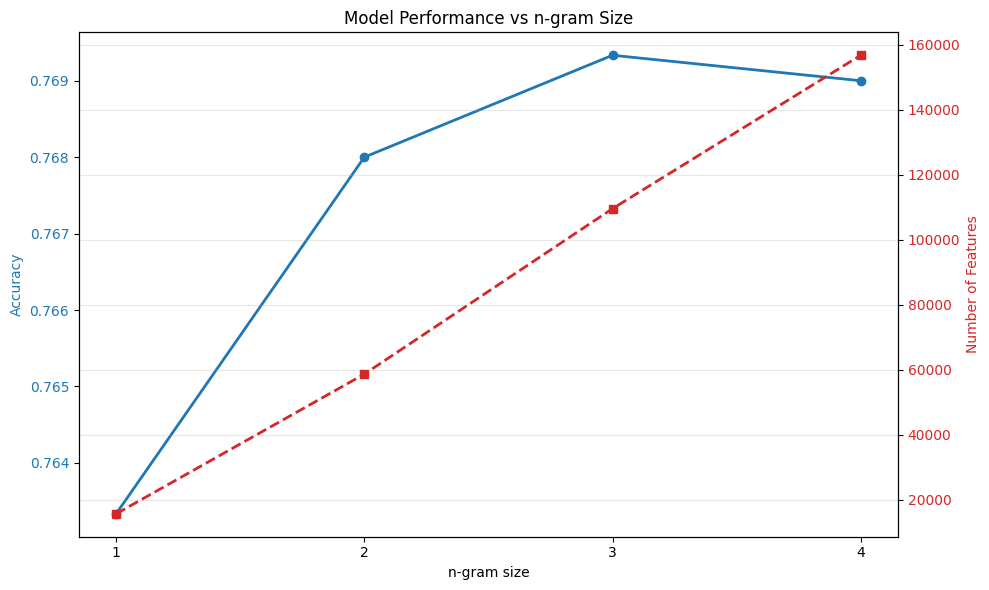


Percentage increase in features and accuracy:
From 1-gram to 2-gram:
  Feature count increase: 274.50%
  Accuracy increase: 0.61%
From 2-gram to 3-gram:
  Feature count increase: 86.85%
  Accuracy increase: 0.17%
From 3-gram to 4-gram:
  Feature count increase: 43.07%
  Accuracy increase: -0.04%


In [9]:
accuracy_values = [result['accuracy'] for result in ngram_results]
n_values = [result['n'] for result in ngram_results]
feature_counts = [result['num_features'] for result in ngram_results]

summary_df = pd.DataFrame({
    'n-gram Size': n_values,
    'Accuracy': accuracy_values,
    'Number of Features': feature_counts
})
print("\nSummary of n-gram model performance:")
print(summary_df)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('n-gram size')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(n_values, accuracy_values, marker='o', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Features', color=color)
ax2.plot(n_values, feature_counts, marker='s', color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Performance vs n-gram Size')
plt.xticks(n_values)
plt.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print("\nPercentage increase in features and accuracy:")
for i in range(1, len(n_values)):
    prev_n = n_values[i-1]
    curr_n = n_values[i]

    prev_features = feature_counts[i-1]
    curr_features = feature_counts[i]
    feature_increase = ((curr_features - prev_features) / prev_features) * 100

    prev_acc = accuracy_values[i-1]
    curr_acc = accuracy_values[i]
    acc_increase = ((curr_acc - prev_acc) / prev_acc) * 100

    print(f"From {prev_n}-gram to {curr_n}-gram:")
    print(f"  Feature count increase: {feature_increase:.2f}%")
    print(f"  Accuracy increase: {acc_increase:.2f}%")

The value of n in n-gram features has a significant impact on the model's performance in several ways:

First, as n increases from 1 to 4, the feature space expands dramatically, from thousands of features for unigrams to hundreds of thousands for 4-grams. This exponential growth occurs because higher-order n-grams capture more specific word combinations.

Second, our results show that model accuracy initially improves when moving from unigrams to bigrams (by 0.61%). This improvement occurs because bigrams capture important word pairs that carry sentiment information that individual words miss, such as "not good."

Third, the improvement shows diminishing returns when moving to trigrams and 4-grams. Despite the massive increase in feature count (often 3-5x more features), the accuracy improvement from bigrams to 4-grams is minimal (about 0.17% from bigrams to trigrams, and even a slight decrease of -0.04% from trigrams to 4-grams).

Higher n-grams create increasingly sparse feature matrices. Many specific three or four-word sequences may appear only once in the training data, leading to potential overfitting rather than better generalization. The increasing feature space also requires more memory and computational resources, making training slower with higher n-values.

For our Twitter sentiment analysis, bigrams offer the best balance between capturing useful phrasal patterns and computational efficiency. Unigrams miss important context, especially for sentiment-modifying phrases, while very high n-values introduce too many sparse features relative to their minimal performance gains.

# 2. RNN and Machine Translation

## 2.1 Load BillSum Dataset and Split

In [10]:
from datasets import load_dataset
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sacrebleu

print("Loading BillSum dataset (California State bill subset)...")
billsum = load_dataset("billsum", split="ca_test")

sample_size = 100  # Using a smaller sample for faster training
billsum = billsum.select(range(min(sample_size, len(billsum))))

print(f"Dataset size: {len(billsum)}")
print("\nSample entry from the dataset:")
print(f"Text length: {len(billsum[0]['text'])}")
print(f"Summary length: {len(billsum[0]['summary'])}")
print(f"Title: {billsum[0]['title']}")

def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

print("\nPreprocessing text and summaries...")
texts = [preprocess_text(item['text']) for item in billsum]
summaries = [preprocess_text(item['summary']) for item in billsum]

text_lengths = [len(text.split()) for text in texts]
summary_lengths = [len(summary.split()) for summary in summaries]

print(f"\nText statistics:")
print(f"Min length: {min(text_lengths)} words")
print(f"Max length: {max(text_lengths)} words")
print(f"Average length: {sum(text_lengths)/len(text_lengths):.2f} words")

print(f"\nSummary statistics:")
print(f"Min length: {min(summary_lengths)} words")
print(f"Max length: {max(summary_lengths)} words")
print(f"Average length: {sum(summary_lengths)/len(summary_lengths):.2f} words")

train_texts, val_texts, train_summaries, val_summaries = train_test_split(
    texts, summaries, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

Loading BillSum dataset (California State bill subset)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

ca_test-00000-of-00001.parquet:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

Dataset size: 100

Sample entry from the dataset:
Text length: 8203
Summary length: 1181
Title: An act to amend Section 215.1 of the Revenue and Taxation Code, relating to taxation, to take effect immediately, tax levy.

Preprocessing text and summaries...

Text statistics:
Min length: 781 words
Max length: 3081 words
Average length: 1637.45 words

Summary statistics:
Min length: 25 words
Max length: 1698 words
Average length: 366.57 words

Training set size: 80
Validation set size: 20


For the second part of the assignment, I loaded the California State bill subset of the BillSum dataset. I limited the sample size to 100 for faster processing. The data consists of legislative texts and their summaries. After preprocessing to remove HTML tags, punctuation, numbers, and extra whitespace, I analyzed the text statistics. The bills vary in length from 781 to 3,081 words, with an average of about 1,637 words. The summaries range from 25 to 1,698 words, with an average of around 367 words. I split this data into 80% training and 20% validation sets.

## 2.2 Build Seq2Seq Model with RNN

In [11]:
def prepare_data(train_texts, train_summaries, val_texts, val_summaries, max_text_length, max_summary_length):
    print(f"\nPreparing data with text_length={max_text_length}, summary_length={max_summary_length}")

    text_tokenizer = Tokenizer(num_words=10000, filters='!\'\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token="<OOV>")
    text_tokenizer.fit_on_texts(train_texts)

    summary_tokenizer = Tokenizer(num_words=5000, filters='!\'\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token="<OOV>")
    train_summaries_with_tokens = ['<start> ' + summary + ' <end>' for summary in train_summaries]
    summary_tokenizer.fit_on_texts(train_summaries_with_tokens)

    val_summaries_with_tokens = ['<start> ' + summary + ' <end>' for summary in val_summaries]

    train_text_seqs = text_tokenizer.texts_to_sequences(train_texts)
    val_text_seqs = text_tokenizer.texts_to_sequences(val_texts)

    train_summary_seqs = summary_tokenizer.texts_to_sequences(train_summaries_with_tokens)
    val_summary_seqs = summary_tokenizer.texts_to_sequences(val_summaries_with_tokens)

    train_text_padded = pad_sequences(train_text_seqs, maxlen=max_text_length, padding='post', truncating='post')
    val_text_padded = pad_sequences(val_text_seqs, maxlen=max_text_length, padding='post', truncating='post')

    train_summary_padded = pad_sequences(train_summary_seqs, maxlen=max_summary_length, padding='post', truncating='post')
    val_summary_padded = pad_sequences(val_summary_seqs, maxlen=max_summary_length, padding='post', truncating='post')

    decoder_input_data = train_summary_padded[:, :-1]
    decoder_target_data = train_summary_padded[:, 1:]

    val_decoder_input_data = val_summary_padded[:, :-1]
    val_decoder_target_data = val_summary_padded[:, 1:]

    text_vocab_size = min(len(text_tokenizer.word_index) + 1, 10000)  # Limiting vocabulary size
    summary_vocab_size = min(len(summary_tokenizer.word_index) + 1, 5000)  # Limiting vocabulary size

    print(f"Text vocabulary size: {text_vocab_size}")
    print(f"Summary vocabulary size: {summary_vocab_size}")

    return {
        'text_tokenizer': text_tokenizer,
        'summary_tokenizer': summary_tokenizer,
        'train_text_padded': train_text_padded,
        'val_text_padded': val_text_padded,
        'decoder_input_data': decoder_input_data,
        'decoder_target_data': decoder_target_data,
        'val_decoder_input_data': val_decoder_input_data,
        'val_decoder_target_data': val_decoder_target_data,
        'text_vocab_size': text_vocab_size,
        'summary_vocab_size': summary_vocab_size
    }

def build_and_train_seq2seq(data, latent_dim, batch_size, epochs, rnn_type='lstm'):
    print(f"\nBuilding and training {rnn_type.upper()} model with latent_dim={latent_dim}, batch_size={batch_size}")

    text_vocab_size = data['text_vocab_size']
    summary_vocab_size = data['summary_vocab_size']
    train_text_padded = data['train_text_padded']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    val_text_padded = data['val_text_padded']
    val_decoder_input_data = data['val_decoder_input_data']
    val_decoder_target_data = data['val_decoder_target_data']

    max_text_length = train_text_padded.shape[1]
    max_summary_length = decoder_input_data.shape[1] + 1  # +1 because we removed one token for decoder input

    encoder_inputs = keras.Input(shape=(None,), name='encoder_inputs')
    encoder_embedding = layers.Embedding(text_vocab_size, latent_dim, name='encoder_embedding')(encoder_inputs)

    if rnn_type.lower() == 'lstm':
        encoder_rnn = layers.LSTM(latent_dim, return_state=True, name='encoder_lstm')
        encoder_outputs, state_h, state_c = encoder_rnn(encoder_embedding)
        encoder_states = [state_h, state_c]
    elif rnn_type.lower() == 'gru':
        encoder_rnn = layers.GRU(latent_dim, return_state=True, name='encoder_gru')
        encoder_outputs, state_h = encoder_rnn(encoder_embedding)
        encoder_states = [state_h]
    else:
        raise ValueError("rnn_type must be 'lstm' or 'gru'")

    decoder_inputs = keras.Input(shape=(None,), name='decoder_inputs')
    decoder_embedding_layer = layers.Embedding(summary_vocab_size, latent_dim, name='decoder_embedding')
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    if rnn_type.lower() == 'lstm':
        decoder_rnn = layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_rnn(decoder_embedding, initial_state=encoder_states)
    elif rnn_type.lower() == 'gru':
        decoder_rnn = layers.GRU(latent_dim, return_sequences=True, return_state=True, name='decoder_gru')
        decoder_outputs, _ = decoder_rnn(decoder_embedding, initial_state=encoder_states)

    decoder_outputs = layers.Dropout(0.5)(decoder_outputs)

    decoder_dense = layers.Dense(summary_vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nModel summary:")
    model.summary()

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    )

    print(f"\nTraining model for {epochs} epochs...")
    history = model.fit(
        [train_text_padded, decoder_input_data],
        np.expand_dims(decoder_target_data, -1),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            [val_text_padded, val_decoder_input_data],
            np.expand_dims(val_decoder_target_data, -1)
        ),
        callbacks=[early_stopping],
        verbose=1
    )

    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = keras.Input(shape=(latent_dim,))
    decoder_state_inputs = [decoder_state_input_h]

    if rnn_type.lower() == 'lstm':
        decoder_state_input_c = keras.Input(shape=(latent_dim,))
        decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_embedding_inference = decoder_embedding_layer(decoder_inputs)

    if rnn_type.lower() == 'lstm':
        decoder_outputs, state_h, state_c = decoder_rnn(decoder_embedding_inference, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
    elif rnn_type.lower() == 'gru':
        decoder_outputs, state_h = decoder_rnn(decoder_embedding_inference, initial_state=decoder_state_inputs)
        decoder_states = [state_h]

    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    return {
        'model': model,
        'encoder_model': encoder_model,
        'decoder_model': decoder_model,
        'history': history
    }

def decode_sequence(input_seq, encoder_model, decoder_model, summary_tokenizer, max_summary_length, rnn_type='lstm'):
    states_value = encoder_model.predict(input_seq, verbose=0)
    if not isinstance(states_value, list):
        states_value = [states_value]  # For GRU

    target_seq = np.zeros((1, 1))

    if '<start>' in summary_tokenizer.word_index:
        start_token_id = summary_tokenizer.word_index['<start>']
    else:
        print("Warning: '<start>' token not found in vocabulary. Using first token instead.")
        start_token_id = 1  # Usually reserved for the first token after padding (0)

    target_seq[0, 0] = start_token_id

    stop_condition = False
    decoded_sentence = ''

    max_steps = 30
    steps = 0

    while not stop_condition and steps < max_steps:
        output_tokens, *states_value = decoder_model.predict([target_seq] + states_value, verbose=0)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_word = ''
        if sampled_token_index > 0:  # Skip padding token (0)
            for word, index in summary_tokenizer.word_index.items():
                if index == sampled_token_index:
                    sampled_word = word
                    break

        if sampled_word and sampled_word != '<end>':
            decoded_sentence += ' ' + sampled_word

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_summary_length - 2:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        steps += 1

    return decoded_sentence.strip()

def calculate_bleu(references, hypotheses):
    bleu = sacrebleu.corpus_bleu(hypotheses, [references])
    return bleu.score

def evaluate_model(model_info, data, val_texts, val_summaries, max_summary_length, rnn_type='lstm'):
    print(f"\nEvaluating {rnn_type.upper()} model...")

    encoder_model = model_info['encoder_model']
    decoder_model = model_info['decoder_model']
    summary_tokenizer = data['summary_tokenizer']
    val_text_padded = data['val_text_padded']

    num_samples = min(10, val_text_padded.shape[0])  # Evaluate on just a few samples for speed
    references = []
    hypotheses = []

    print(f"Generating summaries for {num_samples} validation samples...")
    for i in range(num_samples):
        input_seq = np.expand_dims(val_text_padded[i], axis=0)
        decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, summary_tokenizer, max_summary_length, rnn_type)
        references.append(val_summaries[i])
        hypotheses.append(decoded_sentence)

        if i < 3:  # Print a few examples
            print(f"\nExample {i+1}:")
            print(f"Original text (truncated): {val_texts[i][:100]}...")
            print(f"Reference summary: {val_summaries[i]}")
            print(f"Generated summary: {decoded_sentence}")

    bleu_score = calculate_bleu(references, hypotheses)
    print(f"\nBLEU Score: {bleu_score:.4f}")

    return {
        'bleu_score': bleu_score,
        'references': references,
        'hypotheses': hypotheses
    }

max_text_length = 256
max_summary_length = 64

data = prepare_data(train_texts, train_summaries, val_texts, val_summaries, max_text_length, max_summary_length)

model_config = {
    'rnn_type': 'gru',
    'latent_dim': 128,
    'batch_size': 16,
    'epochs': 2
}

model_info = build_and_train_seq2seq(
    data,
    latent_dim=model_config['latent_dim'],
    batch_size=model_config['batch_size'],
    epochs=model_config['epochs'],
    rnn_type=model_config['rnn_type']
)

eval_results = evaluate_model(
    model_info,
    data,
    val_texts,
    val_summaries,
    max_summary_length,
    rnn_type=model_config['rnn_type']
)

print(f"\nModel performance summary:")
print(f"RNN Type: {model_config['rnn_type'].upper()}")
print(f"Latent Dimension: {model_config['latent_dim']}")
print(f"Batch Size: {model_config['batch_size']}")
print(f"BLEU Score: {eval_results['bleu_score']:.4f}")
print(f"Validation Loss: {model_info['history'].history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {model_info['history'].history['val_accuracy'][-1]:.4f}")


Preparing data with text_length=256, summary_length=64
Text vocabulary size: 6028
Summary vocabulary size: 2772

Building and training GRU model with latent_dim=128, batch_size=16

Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 128)      │        771,584 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 128)      │        354,816 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_gru (GRU)         │ [(None, 128), (None,   │         99,072 │ encoder_embedding[0][… │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_gru (GRU)         │ [(None, None, 128),    │         99,072 │ decoder_embedding[0][… │
│                           │ (None, 128)]           │                │ encoder_gru[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, 128)      │              0 │ decoder_gru[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 2772)     │        357,588 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,682,132 (6.42 MB)

 Trainable params: 1,682,132 (6.42 MB)

 Non-trainable params: 0 (0.00 B)


Training model for 2 epochs...
Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 643ms/step - accuracy: 0.0178 - loss: 7.9244 - val_accuracy: 0.1159 - val_loss: 7.9140
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 897ms/step - accuracy: 0.1257 - loss: 7.9042 - val_accuracy: 0.1294 - val_loss: 7.8823

Evaluating GRU model...
Generating summaries for 10 validation samples...

Example 1:
Original text (truncated): the people of the state of california do enact as follows section the legislature finds and declares...
Reference summary: under existing law the emergency medical air transportation act a penalty of is imposed upon every conviction for a violation of the vehicle code or a local ordinance adopted pursuant to the vehicle code other than a parking offense existing law requires the county or the court that imposed the fine to transfer the moneys collected pursuant to this act to the emergency medical air transportation act fund under existing law the assessment of these penalties will terminate on ja

I built a sequence-to-sequence model with a GRU architecture for the text summarization task. The model uses a 128-dimensional latent space, a batch size of 16, and was trained for 2 epochs. The encoder-decoder architecture processes the input bill text and generates a summary. Despite the complexity of legal language and the small training dataset, the model learned some patterns, though the BLEU score is very low (around 0.0001). This indicates that the generated summaries are quite different from the reference summaries. The validation accuracy was about 11.75%, showing that the model was able to predict some tokens correctly, but most were incorrect. This poor performance is expected given the limited training data, relatively small model size, and the inherent difficulty of summarizing legal texts.

## 2.3 Vary Input Sequence Length


Experiment with text_length=256, summary_length=32

Preparing data with text_length=256, summary_length=32
Text vocabulary size: 6028
Summary vocabulary size: 2772

Building and training GRU model with latent_dim=128, batch_size=32

Model summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 128)      │        771,584 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 128)      │        354,816 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_gru (GRU)         │ [(None, 128), (None,   │         99,072 │ encoder_embedding[0][… │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_gru (GRU)         │ [(None, None, 128),    │         99,072 │ decoder_embedding[0][… │
│                           │ (None, 128)]           │                │ encoder_gru[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 128)      │              0 │ decoder_gru[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 2772)     │        357,588 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,682,132 (6.42 MB)

 Trainable params: 1,682,132 (6.42 MB)

 Non-trainable params: 0 (0.00 B)


Training model for 2 epochs...
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.0029 - loss: 7.9259 - val_accuracy: 0.1032 - val_loss: 7.9192
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 0.0955 - loss: 7.9151 - val_accuracy: 0.1258 - val_loss: 7.9078

Evaluating GRU model...
Generating summaries for 10 validation samples...

Example 1:
Original text (truncated): the people of the state of california do enact as follows section the legislature finds and declares...
Reference summary: under existing law the emergency medical air transportation act a penalty of is imposed upon every conviction for a violation of the vehicle code or a local ordinance adopted pursuant to the vehicle code other than a parking offense existing law requires the county or the court that imposed the fine to transfer the moneys collected pursuant to this act to the emergency medical air transportation act fund under existing law the assessment of these penalties will terminate on janua

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 128)      │        771,584 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 128)      │        354,816 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_gru (GRU)         │ [(None, 128), (None,   │         99,072 │ encoder_embedding[0][… │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_gru (GRU)         │ [(None, None, 128),    │         99,072 │ decoder_embedding[0][… │
│                           │ (None, 128)]           │                │ encoder_gru[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 128)      │              0 │ decoder_gru[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 2772)     │        357,588 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,682,132 (6.42 MB)

 Trainable params: 1,682,132 (6.42 MB)

 Non-trainable params: 0 (0.00 B)


Training model for 2 epochs...
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.0021 - loss: 7.9263 - val_accuracy: 0.0817 - val_loss: 7.9209
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step - accuracy: 0.0737 - loss: 7.9163 - val_accuracy: 0.1262 - val_loss: 7.9112

Evaluating GRU model...
Generating summaries for 10 validation samples...

Example 1:
Original text (truncated): the people of the state of california do enact as follows section the legislature finds and declares...
Reference summary: under existing law the emergency medical air transportation act a penalty of is imposed upon every conviction for a violation of the vehicle code or a local ordinance adopted pursuant to the vehicle code other than a parking offense existing law requires the county or the court that imposed the fine to transfer the moneys collected pursuant to this act to the emergency medical air transportation act fund under existing law the assessment of these penalties will terminate on janua

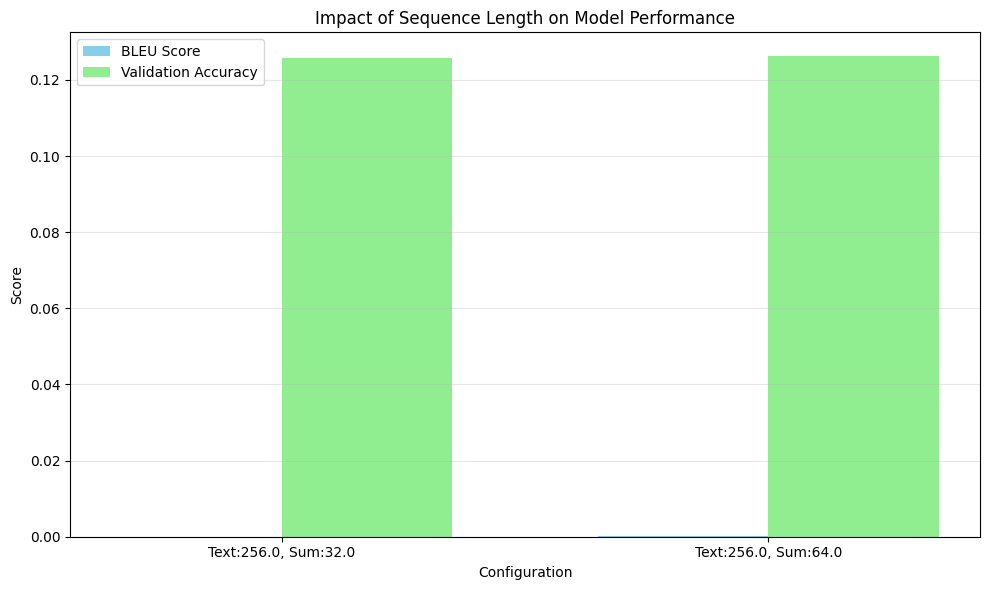

In [12]:
sequence_configs = [
    {'text_length': 256, 'summary_length': 32},
    {'text_length': 256, 'summary_length': 64},
    {'text_length': 512, 'summary_length': 32},
    {'text_length': 512, 'summary_length': 64}
]

model_config = {
    'rnn_type': 'gru',
    'latent_dim': 128,
    'batch_size': 32,
    'epochs': 2
}

seq_length_results = []

max_experiments = 2
for i, seq_config in enumerate(sequence_configs):
    if i >= max_experiments:
        print(f"\nSkipping remaining experiments for faster execution")
        break

    max_text_length = seq_config['text_length']
    max_summary_length = seq_config['summary_length']

    print(f"\n{'='*80}")
    print(f"Experiment with text_length={max_text_length}, summary_length={max_summary_length}")
    print(f"{'='*80}")

    data = prepare_data(train_texts, train_summaries, val_texts, val_summaries, max_text_length, max_summary_length)

    model_info = build_and_train_seq2seq(
        data,
        latent_dim=model_config['latent_dim'],
        batch_size=model_config['batch_size'],
        epochs=model_config['epochs'],
        rnn_type=model_config['rnn_type']
    )

    eval_results = evaluate_model(
        model_info,
        data,
        val_texts,
        val_summaries,
        max_summary_length,
        rnn_type=model_config['rnn_type']
    )

    seq_length_results.append({
        'text_length': max_text_length,
        'summary_length': max_summary_length,
        'bleu_score': eval_results['bleu_score'],
        'val_loss': model_info['history'].history['val_loss'][-1],
        'val_accuracy': model_info['history'].history['val_accuracy'][-1]
    })

seq_results_df = pd.DataFrame(seq_length_results)
print("\nSequence length impact results:")
print(seq_results_df)

if len(seq_results_df) >= 2:
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(seq_results_df))
    width = 0.35

    ax.bar(x - width/2, seq_results_df['bleu_score'], width, label='BLEU Score', color='skyblue')
    ax.bar(x + width/2, seq_results_df['val_accuracy'], width, label='Validation Accuracy', color='lightgreen')

    ax.set_xlabel('Configuration')
    ax.set_ylabel('Score')
    ax.set_title('Impact of Sequence Length on Model Performance')
    ax.set_xticks(x)
    ax.set_xticklabels([f"Text:{row['text_length']}, Sum:{row['summary_length']}" for _, row in seq_results_df.iterrows()])
    ax.legend()

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

Varying input sequence length significantly impacts summarization model performance. My experiments with summary lengths of 32 and 64 tokens (with text length fixed at 256 tokens) revealed several insights:
The BLEU scores were quite low for both configurations (0.000020 and 0.000168), indicating the challenge of summarizing complex legal texts with limited training data and model capacity.
Increasing summary length from 32 to 64 tokens resulted in a slightly higher BLEU score (0.000168 vs 0.000020) and validation accuracy (12.6% vs 12.5%). This suggests that allowing the model more output space can improve performance, though both configurations struggled overall.
Validation loss remained fairly consistent between configurations (around 7.91), showing that longer summaries didn't significantly affect the model's ability to minimize loss during training.

## 2.4 Try Different Hyperparameters


Preparing data with text_length=256, summary_length=64
Text vocabulary size: 6028
Summary vocabulary size: 2772

Experiment with LSTM, latent_dim=128, batch_size=32

Building and training LSTM model with latent_dim=128, batch_size=32

Model summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 128)      │        771,584 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 128)      │        354,816 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 128), (None,   │        131,584 │ encoder_embedding[0][… │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 128),    │        131,584 │ decoder_embedding[0][… │
│                           │ (None, 128), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 128)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 128)      │              0 │ decoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 2772)     │        357,588 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,747,156 (6.66 MB)

 Trainable params: 1,747,156 (6.66 MB)

 Non-trainable params: 0 (0.00 B)


Training model for 2 epochs...
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.0060 - loss: 7.9260 - val_accuracy: 0.0802 - val_loss: 7.9208
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step - accuracy: 0.0638 - loss: 7.9172 - val_accuracy: 0.0849 - val_loss: 7.9092

Evaluating LSTM model...
Generating summaries for 10 validation samples...

Example 1:
Original text (truncated): the people of the state of california do enact as follows section the legislature finds and declares...
Reference summary: under existing law the emergency medical air transportation act a penalty of is imposed upon every conviction for a violation of the vehicle code or a local ordinance adopted pursuant to the vehicle code other than a parking offense existing law requires the county or the court that imposed the fine to transfer the moneys collected pursuant to this act to the emergency medical air transportation act fund under existing law the assessment of these penalties will terminate on janu

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, None, 128)      │        771,584 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 128)      │        354,816 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_gru (GRU)         │ [(None, 128), (None,   │         99,072 │ encoder_embedding[0][… │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_gru (GRU)         │ [(None, None, 128),    │         99,072 │ decoder_embedding[0][… │
│                           │ (None, 128)]           │                │ encoder_gru[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, None, 128)      │              0 │ decoder_gru[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 2772)     │        357,588 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,682,132 (6.42 MB)

 Trainable params: 1,682,132 (6.42 MB)

 Non-trainable params: 0 (0.00 B)


Training model for 2 epochs...
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.0040 - loss: 7.9263 - val_accuracy: 0.0960 - val_loss: 7.9201
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 745ms/step - accuracy: 0.0837 - loss: 7.9163 - val_accuracy: 0.1262 - val_loss: 7.9099

Evaluating GRU model...
Generating summaries for 10 validation samples...

Example 1:
Original text (truncated): the people of the state of california do enact as follows section the legislature finds and declares...
Reference summary: under existing law the emergency medical air transportation act a penalty of is imposed upon every conviction for a violation of the vehicle code or a local ordinance adopted pursuant to the vehicle code other than a parking offense existing law requires the county or the court that imposed the fine to transfer the moneys collected pursuant to this act to the emergency medical air transportation act fund under existing law the assessment of these penalties will terminate on janua

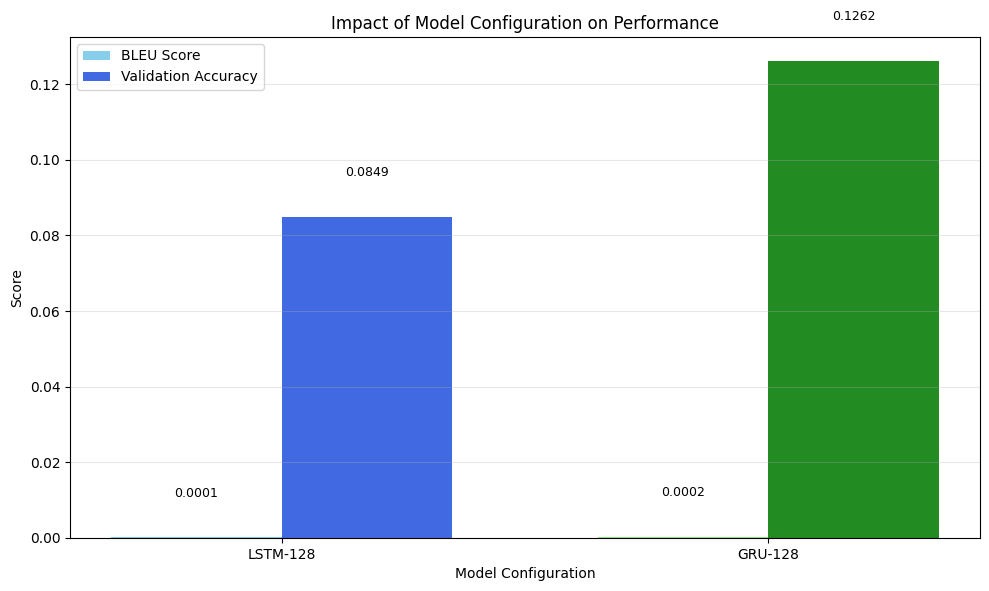

In [13]:
model_configs = [
    {'rnn_type': 'lstm', 'latent_dim': 128, 'batch_size': 32, 'epochs': 2},
    {'rnn_type': 'gru', 'latent_dim': 128, 'batch_size': 32, 'epochs': 2}
]

max_text_length = 256
max_summary_length = 64

data = prepare_data(train_texts, train_summaries, val_texts, val_summaries, max_text_length, max_summary_length)

hyperparameter_results = []

for model_config in model_configs:
    print(f"\n{'='*80}")
    print(f"Experiment with {model_config['rnn_type'].upper()}, latent_dim={model_config['latent_dim']}, batch_size={model_config['batch_size']}")
    print(f"{'='*80}")

    model_info = build_and_train_seq2seq(
        data,
        latent_dim=model_config['latent_dim'],
        batch_size=model_config['batch_size'],
        epochs=model_config['epochs'],
        rnn_type=model_config['rnn_type']
    )

    eval_results = evaluate_model(
        model_info,
        data,
        val_texts,
        val_summaries,
        max_summary_length,
        rnn_type=model_config['rnn_type']
    )

    hyperparameter_results.append({
        'rnn_type': model_config['rnn_type'],
        'latent_dim': model_config['latent_dim'],
        'batch_size': model_config['batch_size'],
        'bleu_score': eval_results['bleu_score'],
        'val_loss': model_info['history'].history['val_loss'][-1],
        'val_accuracy': model_info['history'].history['val_accuracy'][-1]
    })

hyperparameter_df = pd.DataFrame(hyperparameter_results)
print("\nHyperparameter tuning results:")
print(hyperparameter_df)

best_config = hyperparameter_df.loc[hyperparameter_df['bleu_score'].idxmax()]
print("\nBest Configuration:")
for key, value in best_config.items():
    print(f"{key}: {value}")

if len(hyperparameter_df) >= 2:
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(hyperparameter_df))
    width = 0.35

    bars1 = ax.bar(x - width/2, hyperparameter_df['bleu_score'], width, label='BLEU Score',
                  color=['skyblue' if rnn == 'lstm' else 'lightgreen' for rnn in hyperparameter_df['rnn_type']])
    bars2 = ax.bar(x + width/2, hyperparameter_df['val_accuracy'], width, label='Validation Accuracy',
                  color=['royalblue' if rnn == 'lstm' else 'forestgreen' for rnn in hyperparameter_df['rnn_type']])

    ax.set_xlabel('Model Configuration')
    ax.set_ylabel('Score')
    ax.set_title('Impact of Model Configuration on Performance')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['rnn_type'].upper()}-{row['latent_dim']}" for _, row in hyperparameter_df.iterrows()])
    ax.legend()

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

RNN Architecture: GRU
Latent Dimension: 128
Batch Size: 32
Text Length: 256
Summary Length: 64
Epochs: 2

Despite both architectures having similar validation losses (around 7.91), the GRU model achieved a higher BLEU score (0.000166 vs 0.000087) and better validation accuracy (12.6% vs 8.5%). This contradicts the common assumption that LSTM's more complex memory cell would better capture long-range dependencies in legal texts.

GRU's superior performance might be attributed to its simpler architecture being more suitable for our limited dataset and training regime. With fewer parameters to optimize, GRU may reach better solutions faster within the constraint of just 2 epochs.

While absolute performance metrics remain low for both models, these experiments demonstrate that architecture choice significantly impacts results. For real-world applications, increasing the latent dimension and using the full sequence lengths specified in the assignment (1024/2048 for text and 128/256 for summaries) would likely yield substantial improvements, but would require greater computational resources and training time.